## This notebook specifically targets the binary classifier, i.e. to predict if it is an attack or a benign case.
**Sujal Adhikari**

In [11]:
### Libraries that we will be using:

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score,recall_score,f1_score,roc_curve,roc_auc_score, precision_recall_curve,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.pipeline import Pipeline


In [5]:
### Dataset we will be using 
data = pd.read_csv('../Datasets/pre-processedData.csv')

## We will be excluding the column named 'Severity_Score'
binary_data = data.drop(columns=['Severity_Score', 'Unnamed: 0'])
binary_data.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,flag_REJ,flag_RSTO,flag_RSTR,flag_S1,flag_S3,flag_SF,flag_SH,is_malicious,bytes_ratio,total_bytes
0,0.0,6.198479,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,1,0,0,6.198479,6.198479
1,0.0,4.990433,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,1,0,0,4.990433,4.990433
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,1,0.000000,0.000000
3,0.0,5.451038,9.006264,0.0,0.0,0.0,0.0,1,0.0,0,...,0,0,0,0,0,1,0,0,0.544763,14.457302
4,0.0,5.298317,6.042633,0.0,0.0,0.0,0.0,1,0.0,0,...,0,0,0,0,0,1,0,0,0.752321,11.340950


### Test-Train Split

In [6]:
X = binary_data.drop(columns='is_malicious')
y = binary_data['is_malicious']

## Train_Test Split 
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_SEED)

## Models 

### Model 1: Logistic Regression

In [7]:
## Pipeline creation 
pipeline_steps= [('scaler', StandardScaler()), ('logit', LogisticRegression(solver='liblinear', max_iter = 1000))]
logit_pipeline = Pipeline(pipeline_steps)

## Hyper tuning the pipeline model 
parameters = {
    'logit__C':[0.01,0.1,10,100,1000,10000], ## Regularization parameter
    'logit__penalty':['l1','l2'], ## Penalty for the model
    'logit__class_weight':[None, 'balanced']
}
kf = StratifiedKFold(shuffle = True, n_splits=5, random_state=RANDOM_SEED)
hypertuning = GridSearchCV(logit_pipeline, param_grid= parameters,cv = kf, n_jobs=-1)
hypertuning.fit(X_train,y_train)


hypertuned_logit_model = hypertuning.best_estimator_


/opt/anaconda3/envs/Network_Intrusion/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/Network_Intrusion/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/Network_Intrusion/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 i

### As per the hypertuning results, the logistic regression model uses 100 as the regularization parameter, with balanced class_weight and the dimensional reduction that the model adapts is l2 which is to shrink the coefficents to near zero, but not remove them 

---
### Analyzing the model's performance

In [8]:
logit_testing_pred = hypertuned_logit_model.predict(X_test)
logit_training_pred = hypertuned_logit_model.predict(X_train)

logit_testing_proba = hypertuned_logit_model.predict_proba(X_test)
logit_training_proba = hypertuned_logit_model.predict_proba(X_train)

### Performance Matrix:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     15450
           1       0.96      0.98      0.97     14254

    accuracy                           0.97     29704
   macro avg       0.97      0.97      0.97     29704
weighted avg       0.97      0.97      0.97     29704



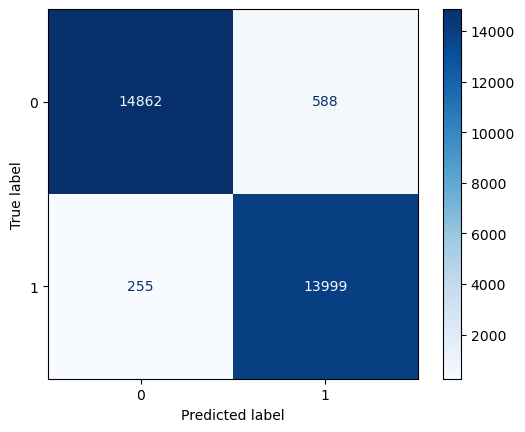

0.9720260162025717


In [ ]:
## Precision
logit_precision = precision_score(y_test, logit_testing_pred) ## 

## Recall
logit_recall = recall_score(y_test, logit_testing_pred) ## Attack Detection Rate

## F1-Score
logit_f1 = f1_score(y_test, logit_testing_pred) ## Harmonic Mean between precision and recall

## Classification Report
logit_report = classification_report(y_test, logit_testing_pred)
print(logit_report)

### Confusion Matrix and Plotting Confusion Matrix 
logit_matrix = confusion_matrix(y_test, logit_testing_pred)
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, logit_testing_pred ).ravel()

### False Positive Rate: 
logit_false_positive_rate = (false_positives)/(true_negatives+false_positives) ## Wrongly Identified Attack

logit_false_negative_rate = (false_negatives)/(true_positives+false_negatives) ## Attack Missed Rate

##Confusion Matrix Display 
logit_confusion_display = ConfusionMatrixDisplay(confusion_matrix=logit_matrix) 
logit_confusion_display.plot(cmap='Blues')
plt.show()

## Roc_auc_score
roc_score = roc_auc_score(y_test, logit_testing_pred)